In [68]:
import pandas as pd
from os.path import join
import regex as re
import string
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from afinn import Afinn
import dateutil.parser as dparser
import spacy
from pandarallel import pandarallel
from spacy import displacy
from nltk.tokenize import word_tokenize
import requests
from json.decoder import JSONDecodeError
from multiprocessing.dummy import Pool as ThreadPool
import json
import plotly.express as px
import itertools
import plotly.graph_objects as go
import datetime


sns.set_theme()
pandarallel.initialize(progress_bar = False)

# Constants
DBPEDIA_ENDPOINT = "https://api.dbpedia-spotlight.org/en/annotate"
POOL_SIZE = 30

# Serialization folder
SERIALIZATION_FOLDER = "pickle/"

# Environment
DATA_PATH = 'data/'
EMAIL_DATA = 'Emails.csv'


TOP_K = 30

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Read dataframe

In [69]:
df = pd.read_csv(join(DATA_PATH, EMAIL_DATA))

# Subset useful fields
df = df[['Id', 'SenderPersonId', 'MetadataDateSent',
         'ExtractedSubject', 'ExtractedBodyText']]
# Preprocess dataframe data
df = df.astype({'Id': int})
df = df.set_index('Id')

# Drop na values based on Extracted body
len_before = len(df)
df = df[df['ExtractedBodyText'].notna()]
df = df[df['MetadataDateSent'].notna()]

# Parse date
df["MetadataDateSent"] = df["MetadataDateSent"].apply(lambda x : dparser.parse(x))
df["DateYear"] = df["MetadataDateSent"].apply(lambda x : x.year)
df["DateMonth"] = df["MetadataDateSent"].apply(lambda x : x.month)
df["DateDay"] = df["MetadataDateSent"].apply(lambda x : x.day)

print(f"Number of NA values in body and date: {len_before - len(df)}.\n"
      f"Number of valid email: {len(df)}")
df.head()

Number of NA values in body and date: 1208.
Number of valid email: 6737


,SenderPersonId,MetadataDateSent,ExtractedSubject,ExtractedBodyText,DateYear,DateMonth,DateDay
Id,,,,,,,
2,NaN,2011-03-03 05:00:00+00:00,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",2011,3,3
3,32.0,2012-09-12 04:00:00+00:00,Re: Chris Stevens,Thx,2012,9,12
5,80.0,2011-03-11 05:00:00+00:00,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",2011,3,11
6,80.0,2012-09-12 04:00:00+00:00,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,2012,9,12
8,80.0,2011-03-11 05:00:00+00:00,NaN,"H <hrod17@clintonemail.corn>\nFriday, March 11...",2011,3,11


Date and time distribution.

Since the emails belong to Hilary Clinton's personal account instead of the institutional one, we should notice few emails sent during weekdays.

/Users/gianlucagiudice/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



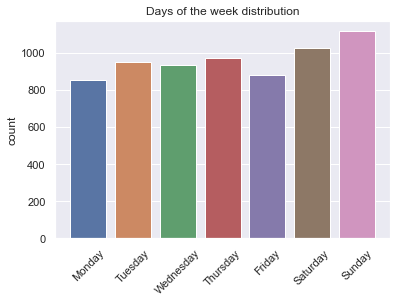

In [70]:
def plot_days_dist(days_metadata):
    days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    days = [date.strftime("%A") for date in df[days_metadata.notnull()]["MetadataDateSent"]]
    sns.countplot(days, order=days_order)
    plt.xticks(rotation=45)
    plt.title("Days of the week distribution")
    plt.plot()

plot_days_dist(df["MetadataDateSent"])


Preprocessing

In [71]:
# Body preprocessing
def clean_body(body):
    email_header = re.compile(r'.+[^<]+<[^>]+>', re.IGNORECASE)
    re_header = re.compile(r'(Delivered:\s+)?RE:[^\n]+\n', re.IGNORECASE)
    fw_header = re.compile(r'FW:[^\n]+\n', re.IGNORECASE)
    date_header = re.compile(r'\w+,\s\w+\s\d+,\s\d+[^\n]+\n', re.IGNORECASE)
    # Convert to lowercase
    body = body.lower()
    # Remove email
    body = re.sub(email_header, '', body).strip()
    # Remove "FW:"
    body = re.sub(fw_header, '', body).strip()
    # Remove "RE:"
    body = re.sub(re_header, '', body).strip()
    # Remove date
    body = re.sub(date_header, '', body).strip()
    return body

sample = df['ExtractedBodyText'].loc[230]
print('>>> Raw:\n' + sample)
print('>>> Cleaned:\n' + clean_body(sample))

>>> Raw:
Brennan, John 0.
Subject: RE: Google and YouTube
Sue just called back and the block will stay through Monday. They will not/not be unblocking it before then.
Nora Toiv
Office of the Secretary
202-647-8633
>>> Cleaned:
brennan, john 0.
subject: sue just called back and the block will stay through monday. they will not/not be unblocking it before then.
nora toiv
office of the secretary
202-647-8633


Drop the emails that are too short

In [72]:
def tokenize_body(body):
    tokenized = word_tokenize(body)
    # Strip tokens
    tokenized = [token.strip() for token in tokenized]

    # --------- STRICT RULE ---------
    # Strict regex rule
    tokenized = [token for token in tokenized if re.match('\w+', token)]
    # --------- STRICT RULE ---------

    # Remove punctuation
    tokenized = [token for token in tokenized if token not in string.punctuation]
    # Remove stopwords
    stop = stopwords.words('english') + [':', '.', '@'] + ["n't"]
    tokenized = [token for token in tokenized if token not in stop]
    # Remove numbers
    tokenized = [token for token in tokenized if not re.search(r'\d', token)]
    return tokenized

to_tokenize = clean_body(sample)
tokenize_body(to_tokenize)

['brennan',
 'john',
 'subject',
 'sue',
 'called',
 'back',
 'block',
 'stay',
 'monday',
 'not/not',
 'unblocking',
 'nora',
 'toiv',
 'office',
 'secretary']

In [73]:
def process_body(body):
    body = clean_body(body)
    tokenized = tokenize_body(body)
    return tokenized

In [74]:
df['Tokenized'] = df['ExtractedBodyText'].parallel_apply(process_body)
df.to_pickle(SERIALIZATION_FOLDER + "df.pkl")
df.head()

,SenderPersonId,MetadataDateSent,ExtractedSubject,ExtractedBodyText,DateYear,DateMonth,DateDay,ExtractedBodyTextCleaned,Tokenized
Id,,,,,,,,,
2,NaN,2011-03-03 05:00:00+00:00,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",2011,3,3,b6\nh: latest how syria is aiding qaddafi and ...,"[h, latest, syria, aiding, qaddafi, sid, hrc, ..."
3,32.0,2012-09-12 04:00:00+00:00,Re: Chris Stevens,Thx,2012,9,12,thx,[thx]
5,80.0,2011-03-11 05:00:00+00:00,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",2011,3,11,huma abedin\nhrc memo syria aiding libya 03031...,"[huma, abedin, hrc, memo, syria, aiding, libya..."
6,80.0,2012-09-12 04:00:00+00:00,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,2012,9,12,°russorv@state.gov'\nfrom [meat)\nsent: to: 11...,"[state.gov', meat, sent, subject, meet, right,..."
8,80.0,2011-03-11 05:00:00+00:00,NaN,"H <hrod17@clintonemail.corn>\nFriday, March 11...",2011,3,11,huma abedin\nhrc memo syria aiding libya 03031...,"[huma, abedin, hrc, memo, syria, aiding, libya..."


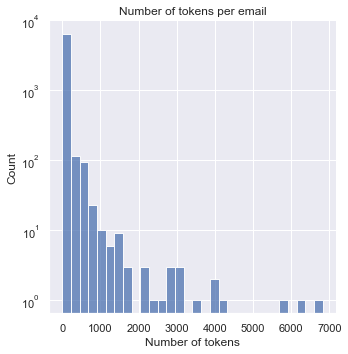

Describe tokens length: count    6737.000000
mean       45.375241
std       229.673265
min         0.000000
25%         2.000000
50%         6.000000
75%        16.000000
max      6828.000000
Name: TokensLength, dtype: float64


In [75]:
def plot_tokens_distribution(values):
    ax = sns.displot(values, log=True, bins=30)
    ax.set_xlabels("Number of tokens")
    plt.title("Number of tokens per email")
    plt.show()
    print("Describe tokens length:", values.describe())

df['TokensLength'] = [len(x) for x in df['Tokenized']]

plot_tokens_distribution(df['TokensLength'])

Wordcloud of the emails with few tokens

In [76]:
TOKENS_THLD = 7
def flatten_tokens(tokens_list):
    words_flatten = []
    for token in tokens_list:
        words_flatten += token
    return pd.Series(words_flatten)

def plot_wordcloud(words_freq, title, max_font, max_words):
    wordcloud = WordCloud(max_font_size=max_font, max_words=max_words)
    wordcloud = wordcloud.generate_from_frequencies(words_freq)
    plt.figure()
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

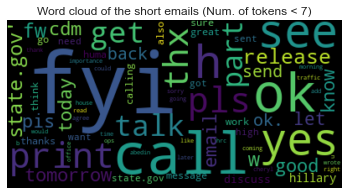

In [77]:
words_flatten = flatten_tokens(df[df["TokensLength"] < TOKENS_THLD]["Tokenized"])
title = f"Word cloud of the short emails (Num. of tokens < {TOKENS_THLD})"
plot_wordcloud(words_flatten.value_counts(), title, 100, 70)

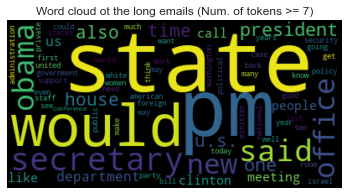

In [78]:
words_flatten = flatten_tokens(df[df["TokensLength"] > TOKENS_THLD]["Tokenized"])
title = f"Word cloud ot the long emails (Num. of tokens >= {TOKENS_THLD})"
plot_wordcloud(words_flatten.value_counts(), title, 100, 70)

Named entity Recognition and linking on nations

In [79]:
nlp = spacy.load("en_core_web_md")
afn = Afinn()

def extract_entities(email_body, target_label):
    entities = [ent for ent in nlp(email_body).ents if ent.label_ == target_label]
    return [(entity.text.lower(), afn.score(entity.sent.lemma_)) for entity in entities]

Slides demo

In [80]:
def named_entity_recognition_demo():
    doc = """[...] The United States should immediately ask the Security Council to authorize a no-flight zone and make clear to Russia and China that if they block the resolution, the blood of the Libyan opposition will be on their hands. [...]"""
    displacy.render(nlp(doc), style="ent", jupyter=True)
named_entity_recognition_demo()

In [81]:
df["EntitiesGPE"] = df["ExtractedBodyText"].parallel_apply(extract_entities, target_label='GPE')
df["EntitiesGPE"].head()

Id
2    [(syria, 0.0), (qaddafi, 0.0), (libya, 0.0), (...
3                                                   []
5         [(syria, 0.0), (qaddafi, 0.0), (libya, 0.0)]
6                                       [(u.s., -1.0)]
8    [(syria, 0.0), (qaddafi, 0.0), (syria, 0.0), (...
Name: EntitiesGPE, dtype: object

Aggregate (sum) the sentiment among emails.

If an entity appears one or more times in the email, its frequency contribution is 1.

In [82]:
def evaluate_entities(entities_list, order='freq'):
    entity_score = dict()
    freq_dict = dict()
    for entities in entities_list:
        entities_set = set()
        for entity, sentiment in entities:
            entity_score[entity] = entity_score.get(entity, 0) + sentiment
            entities_set.add(entity)
        for entity in entities_set:
            freq_dict[entity] = freq_dict.get(entity, 0) + 1
    out_dict = dict()
    for entity, frequnecy in freq_dict.items():
        out_dict[entity] = {
            "score": entity_score[entity],
            "freq": frequnecy,
            "norm": entity_score[entity] / frequnecy}
    return {k: v for k, v in sorted(out_dict.items(), key=lambda item: item[1][order], reverse=True)}

def clean_entities(entities, blacklist):
    for target in map(lambda x: x.lower(), blacklist):
        if entities.get(target) is not None :
            del entities[target]
    return entities

In [83]:
entities_to_remove = ['U.S.', 'US', 'the United States', 'America', 'usa',
                      "washington", "new york", "dc", "united states"]
entities_gpe = evaluate_entities(df['EntitiesGPE'])
entities_gpe = clean_entities(entities_gpe, entities_to_remove)
print(list(entities_gpe.items())[:15])


[('iran', {'score': -50.0, 'freq': 101, 'norm': -0.49504950495049505}), ('afghanistan', {'score': 28.0, 'freq': 100, 'norm': 0.28}), ('china', {'score': 109.0, 'freq': 85, 'norm': 1.2823529411764707}), ('israel', {'score': 177.0, 'freq': 73, 'norm': 2.4246575342465753}), ('pakistan', {'score': 103.0, 'freq': 70, 'norm': 1.4714285714285715}), ('iraq', {'score': -76.0, 'freq': 68, 'norm': -1.1176470588235294}), ('haiti', {'score': 102.0, 'freq': 63, 'norm': 1.619047619047619}), ('libya', {'score': -27.0, 'freq': 55, 'norm': -0.4909090909090909}), ('russia', {'score': -1.0, 'freq': 54, 'norm': -0.018518518518518517}), ('india', {'score': 127.0, 'freq': 52, 'norm': 2.4423076923076925}), ('ny', {'score': 15.0, 'freq': 49, 'norm': 0.30612244897959184}), ('uk', {'score': -5.0, 'freq': 41, 'norm': -0.12195121951219512}), ('london', {'score': 5.0, 'freq': 41, 'norm': 0.12195121951219512}), ('hrc', {'score': 47.0, 'freq': 34, 'norm': 1.3823529411764706}), ('turkey', {'score': 18.0, 'freq': 33, '

Entity linking using DBpedia Spotlights

In [84]:
def entity_linking(*args):
    entity, session = args
    params = {"text": entity, "confidence":0.1}
    headers = {"accept": "application/json"}
    response_url = session.get(url=DBPEDIA_ENDPOINT, params=params, headers=headers)
    try:
        parsed = json.loads(response_url.content.decode())
        return parsed["Resources"][0]['@URI']
    except (IndexError, KeyError, JSONDecodeError):
        return None

def resolve_entities(entities: dict) -> dict:
    with ThreadPool(POOL_SIZE) as pool:
        with requests.Session() as session:
            session_to_zip = itertools.repeat(session, len(entities))
            results = pool.starmap(entity_linking, zip(entities.keys(), session_to_zip))

    entities_resolved = entities
    for (entity, entity_dict), dbpedia in zip(entities.items(), results):
        entity_dict.update([('dbpedia', dbpedia)])
        entities_resolved[entity] = entity_dict
    return entities_resolved


In [85]:
entities_gpe = resolve_entities(entities_gpe)
print(list(entities_gpe.items())[:15])

[('iran', {'score': -50.0, 'freq': 101, 'norm': -0.49504950495049505, 'dbpedia': 'http://dbpedia.org/resource/Iran'}), ('afghanistan', {'score': 28.0, 'freq': 100, 'norm': 0.28, 'dbpedia': 'http://dbpedia.org/resource/Afghanistan'}), ('china', {'score': 109.0, 'freq': 85, 'norm': 1.2823529411764707, 'dbpedia': 'http://dbpedia.org/resource/China'}), ('israel', {'score': 177.0, 'freq': 73, 'norm': 2.4246575342465753, 'dbpedia': 'http://dbpedia.org/resource/Israel'}), ('pakistan', {'score': 103.0, 'freq': 70, 'norm': 1.4714285714285715, 'dbpedia': 'http://dbpedia.org/resource/Pakistan'}), ('iraq', {'score': -76.0, 'freq': 68, 'norm': -1.1176470588235294, 'dbpedia': 'http://dbpedia.org/resource/Iraq'}), ('haiti', {'score': 102.0, 'freq': 63, 'norm': 1.619047619047619, 'dbpedia': 'http://dbpedia.org/resource/Haiti'}), ('libya', {'score': -27.0, 'freq': 55, 'norm': -0.4909090909090909, 'dbpedia': 'http://dbpedia.org/resource/Libya'}), ('russia', {'score': -1.0, 'freq': 54, 'norm': -0.0185185

Plot nations sentiment using

In [86]:
def build_entities_df(entities):
    df_entities = pd.DataFrame(columns=["entity", "score", "freq"])
    for entity, entity_dict in entities.items():
        row = {"entity": entity, "score": entity_dict["score"],
               "freq": entity_dict["freq"], "dbpedia": entity_dict["dbpedia"]}
        df_entities = df_entities.append(row, ignore_index=True)

    df_entities.sort_values(by=['freq'])
    df_entities = df_entities.astype(dict(freq=float))
    df_entities["norm"] = df_entities["score"] / df_entities["freq"]
    df_entities = df_entities.dropna()
    return df_entities

def plot_entitites_sentiment(df_entities):
    fig = px.scatter(df_entities, x="score", y="freq", text="entity", size="freq",
                     color="score", color_continuous_scale="Bluered_r")
    fig.update_traces(textposition='top right')
    fig.update_layout(
        xaxis_title="Sentiment Score",
        yaxis_title="Frequency",
        title= dict(
            text=f'Sentiment of the nations (top {TOP_K} by frequency)',
            xanchor='center',
            x=0.5)
    )
    fig.update_traces(marker=dict(size=15), selector=dict(mode='markers'))
    fig.show()

def plot_entities_normalized(df_entities):
    df_entities_sub = df_entities.sort_values(by="norm", ascending=False)
    df_entities_sub.head()

    fig = px.bar(x=df_entities_sub["entity"], y=df_entities_sub["norm"],
                 color=df_entities_sub["norm"], color_continuous_scale="Bluered_r")

    fig.update_layout(
        yaxis_title="Sentiment Score normalized",
        xaxis_title="Entity",
        title= dict(
            text=f'Sentiment of the nations normalized (top {TOP_K} by frequency)',
            xanchor='center',
            x=0.5),
        coloraxis_colorbar=dict(title="Sentiment")
    )
    fig.show()

In [87]:
df_entities = build_entities_df(entities_gpe)
df_entities.head()

,entity,score,freq,dbpedia,norm
0,iran,-50.0,101.0,http://dbpedia.org/resource/Iran,-0.495050
1,afghanistan,28.0,100.0,http://dbpedia.org/resource/Afghanistan,0.280000
2,china,109.0,85.0,http://dbpedia.org/resource/China,1.282353
3,israel,177.0,73.0,http://dbpedia.org/resource/Israel,2.424658
4,pakistan,103.0,70.0,http://dbpedia.org/resource/Pakistan,1.471429


In [88]:
plot_entitites_sentiment(df_entities.iloc[:TOP_K])

In [89]:
plot_entities_normalized(df_entities.iloc[:TOP_K])

Plot on map

In [90]:
from SPARQLWrapper import SPARQLWrapper, JSON

def dbpedia_get_geo(uri):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = r'select distinct ?lat ?long where {<' + uri +\
            '> geo:lat ?lat. <'+uri+'> geo:long ?long.}'

    try:
        sparql.setQuery(query)
        # Convert results to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()["results"]["bindings"][0]
        lat, long = float(result["lat"]["value"]), float(result["long"]["value"])
        return uri, lat, long
    except (KeyError, IndexError):
        return uri, None, None

def resolve_geo_info(df):
    df = df.dropna()
    dbpedia_uris = df["dbpedia"]
    with ThreadPool(POOL_SIZE) as pool:
        results = pool.map(dbpedia_get_geo, dbpedia_uris)
    # Append geo info
    df_geo = pd.DataFrame(results, columns=["dbpedia", "lat", "long"])
    #df_geo = pd.concat([df, df_geo], axis=1)
    df = df.join(df_geo.set_index("dbpedia"), on='dbpedia')
    df = df.dropna()
    return df


In [91]:
df_geo = resolve_geo_info(df_entities.iloc[:TOP_K])
df_geo.head()

,entity,score,freq,dbpedia,norm,lat,long
0,iran,-50.0,101.0,http://dbpedia.org/resource/Iran,-0.495050,32.0000,51.4167
1,afghanistan,28.0,100.0,http://dbpedia.org/resource/Afghanistan,0.280000,33.0000,65.0000
2,china,109.0,85.0,http://dbpedia.org/resource/China,1.282353,39.9167,116.3830
3,israel,177.0,73.0,http://dbpedia.org/resource/Israel,2.424658,31.0000,35.0000
4,pakistan,103.0,70.0,http://dbpedia.org/resource/Pakistan,1.471429,30.0000,70.0000


In [92]:
fig = px.scatter_geo(df_geo, lat = "lat", lon="long", hover_name="entity", size="freq",
                     color="norm", color_continuous_scale="Bluered_r")

fig.update_layout(
    title= dict(
        text='Sentiment of the nations (top 30 by frequency)',
        xanchor='center',
        x=0.5, y=0.9)
)
#fig.update_traces(marker=dict(size=10))
fig.update_layout(margin={"r":50,"t":0,"l":50,"b":0})
fig.show()



In [93]:
fig = go.Figure(
    data=go.Choropleth(    
    locations = df_geo['entity'],
    z = df_geo['score'] /  df_geo['freq'],
    text = df_geo['entity'],
    # Greys,YlGnBu,Greens,YlOrRd,Bluered,RdBu,Reds,
    # Blues,Picnic,Rainbow,Portland,Jet,Hot,Blackbody,Earth,Electric,Viridis,Cividis.     
    colorscale = 'Bluered',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Score',
))

fig.update_layout(
    title_text='Sentiment associated to countries',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        showarrow = False,
        text="Hillary Clinton's emails" 
    )]
)

fig.update_traces(locationmode="country names", selector=dict(type='choropleth'))

fig.show()

Plot entities over time

In [94]:
def parse_entities_name(entities):
    if entities:
        return [e[0] for e in entities]
    else:
        return []
df["EntitiesGPEName"] = df["EntitiesGPE"].apply(parse_entities_name)

In [95]:
df_nations = df.groupby(by=["DateYear", "DateMonth"]).apply(lambda x : list(x["EntitiesGPEName"]))
df_nations = pd.DataFrame(df_nations, columns=["Entities"]).reset_index()
df_nations["Entities"] = df_nations.reset_index()["Entities"].apply(lambda x:list(itertools.chain(*x)))
df_nations["Entities"] = df_nations["Entities"].apply(lambda x: x if x!= [] else None )
df_nations = df_nations.dropna()
df_nations["Date"] = [datetime.datetime(x["DateYear"], x["DateMonth"], 1) for _, x in df_nations.iterrows()]
dx = pd.period_range(min(df_nations.Date), max(df_nations.Date), freq='M')
dx = [datetime.datetime(x.year, x.month, 1) for x in dx]
ts = pd.DataFrame(dx, columns=["Date"])
df_nations = pd.merge(df_nations, ts, on="Date", how="outer").sort_values(by=["Date"])
df_nations["Entities"] = df_nations["Entities"].apply(lambda x : x if type(x) is list else [])
df_nations["Freq"] = df_nations["Entities"].apply(lambda x: len(x) if x != None else [])
df_nations = df_nations.sort_values(by=["Date"])
df_nations.head()

,DateYear,DateMonth,Entities,Date,Freq
0,2009.0,3.0,"[hrc, washington, washington, madagascar, u.s....",2009-03-01,22
1,2009.0,4.0,"[hrc, mexico, durban, states, washington, camb...",2009-04-01,268
2,2009.0,5.0,"[holbrooke, karzai, liberia, kazakhstan, india...",2009-05-01,147
3,2009.0,6.0,"[washington, dc, israel, morocco, no ireland, ...",2009-06-01,253
4,2009.0,7.0,"[santa, haiti, dc, ny, kurdistan, us, hrc, sor...",2009-07-01,250


In [96]:
fig = px.area(df_nations, x='Date', y="Freq")
fig.update_layout(
    yaxis_title="Frequency",
    xaxis_title="Date",
    title= dict(
        text=f'Frequency of nations by date',
        xanchor='center',
        x=0.5)
)
fig.show()

In [97]:
TOP_K_CATEGORY = 4
top_positive = df_entities.iloc[:TOP_K].sort_values(by=["norm"], ascending=False).iloc[:TOP_K_CATEGORY]
top_negative = df_entities.iloc[:TOP_K].sort_values(by=["norm"], ascending=True).iloc[:TOP_K_CATEGORY]
top_entities = pd.concat([top_positive, top_negative])
top_entities

,entity,score,freq,dbpedia,norm
27,indonesia,89.0,21.0,http://dbpedia.org/resource/Indonesia,4.238095
9,india,127.0,52.0,http://dbpedia.org/resource/India,2.442308
3,israel,177.0,73.0,http://dbpedia.org/resource/Israel,2.424658
22,brazil,41.0,24.0,http://dbpedia.org/resource/Brazil,1.708333
30,benghazi,-114.0,20.0,http://dbpedia.org/resource/Benghazi,-5.700000
31,north korea,-33.0,20.0,http://dbpedia.org/resource/North_Korea,-1.650000
5,iraq,-76.0,68.0,http://dbpedia.org/resource/Iraq,-1.117647
28,britain,-16.0,21.0,http://dbpedia.org/resource/United_Kingdom,-0.761905


In [98]:
df_nations.head()

,DateYear,DateMonth,Entities,Date,Freq
0,2009.0,3.0,"[hrc, washington, washington, madagascar, u.s....",2009-03-01,22
1,2009.0,4.0,"[hrc, mexico, durban, states, washington, camb...",2009-04-01,268
2,2009.0,5.0,"[holbrooke, karzai, liberia, kazakhstan, india...",2009-05-01,147
3,2009.0,6.0,"[washington, dc, israel, morocco, no ireland, ...",2009-06-01,253
4,2009.0,7.0,"[santa, haiti, dc, ny, kurdistan, us, hrc, sor...",2009-07-01,250


In [101]:
import collections


fig = go.Figure()

for entity in top_entities["entity"]:
    x = df_nations["Date"]
    y = []
    for x_date in df_nations["Date"]:
        nations = df_nations.query(f'Date=="{x_date}"')["Entities"].values[0]
        counts = collections.Counter(nations)
        y.append(counts[entity])
    fig.add_trace(go.Scatter(x=df_nations["Date"], y=y, name=entity))

# Edit the layout
fig.update_layout(
    yaxis_title="Frequency",
    xaxis_title="Date",
    title= dict(
        text=f'Frequency of most influent nations by date',
        xanchor='center',
        x=0.5, y=.9)
)

fig.show()

Named entity Recognition and linking on dates to find hilary's schedule of the day


